In [20]:
'''
利用无监督学习进行股票数据分析：
因为不知道股票市场有多少集群，因此需要用一种紧邻传播聚类算法（Affinity Propagation）
该算法会找出每个集群中的代表性datapoint，根据相似性度量值，进行聚类

本例：试分析特定时间内的股票市场变化，根据股价波动找出公司行为的相似性
'''
import json
import datetime
import numpy as np
from sklearn import covariance, cluster
#from matplotlib.finance import quotes_historical_yahoo_ochl as quotes_yahoo

'''
symbol_file = 'symbol_map.json'
# 加载符号映射信息
with open(symbol_file,'r') as f:
    symbol_dict = json.loads(f.read())
    
symbols, names = np.array(list(symbol_dict.items())).T
#print(symbol_dict[:5])
#print(symbols[:5])
#print(names[:5])

# 指定要分析的时间段
start_time = datetime.datetime(2004,4,5)
end_time = datetime.datetime(2007,6, 2)
'''

# Extract the required values
quotes = []
with open('yahoofinance-AAPL-20040819-20180120.csv','r') as f:
    for line in f.readlines():
        quotes.append([x for x in line[:-1].split(',')])
        
dates = np.array([quote[0] for quote in quotes])

opening_quotes = np.array([quote[1] for quote in quotes]).astype(np.float)
closing_quotes = np.array([quote[4] for quote in quotes]).astype(np.float)
delta_quotes = closing_quotes - opening_quotes

# 从相关性中建立协方差模型
edge_model = covariance.GraphicalLassoCV()

# 使用数据之前，进行数据标准化
X = delta_quotes.copy().T
X /= X.std(axis=0)
print(X[0])
X = np.array(X).reshape(1,-1)
print(X[0])
'''
# training
with np.errstate(invalid='ignore'):
    edge_model.fit(X)

_, labels = cluster.affinity_propagation(edge_model.covariance_)
num_labels = labels.max()

for i in range(num_labels + 1):
    print('Cluster', i+1, '-->',', '.join(names[labels == i]))

'''

-0.06372822487912984
[-0.06372822  0.00716989  0.0175249  ...  3.28997477 -0.12267653
 -0.16727948]


"\n# training\nwith np.errstate(invalid='ignore'):\n    edge_model.fit(X)\n\n_, labels = cluster.affinity_propagation(edge_model.covariance_)\nnum_labels = labels.max()\n\nfor i in range(num_labels + 1):\n    print('Cluster', i+1, '-->',', '.join(names[labels == i]))\n\n"


Number of clusters in input_data : 8

Centroids of clusters:
Fre	Mil	Gro	Fro	Det	Del
9632	4671	6593	2570	2296	1248
40204	46314	57584	5518	25436	4241
112151	29627	18148	16745	4948	8550
36847	43950	20170	36534	239	47943
32717	16784	13626	60869	1272	5609
22925	73498	32114	987	20070	903
16117	46197	92780	1026	40827	2944
8565	4980	67298	131	38102	1215


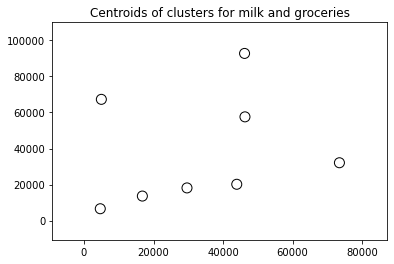

In [14]:
'''
建立客户细分模型
根据不同类型商品的销售数据，找到数据集群，从而为客户提供最优的销售和分销策略
'''
import csv
import numpy as np
from sklearn import cluster, covariance, manifold
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

# load data
input_file = 'wholesale.csv'
file_reader = csv.reader(open(input_file,'r'),delimiter=',')
X = []

for count, row in enumerate(file_reader):
    if not count: # 第一行
        names = row[2:]
        continue
    X.append([float(x) for x in row[2:]])

X = np.array(X)

# 建立 均值漂移聚类模型
# 估计带宽参数
bandwidth = estimate_bandwidth(X, quantile=0.8, n_samples=len(X))

# 均值聚类函数
meanshift_estimator = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift_estimator.fit(X)
labels = meanshift_estimator.labels_
centroids = meanshift_estimator.cluster_centers_
num_clusters = len(np.unique(labels))

print("\nNumber of clusters in input_data :",num_clusters)

# 打印集群中心
print("\nCentroids of clusters:")
print('\t'.join([name[:3] for name in names]))
for centroid in centroids:
    print("\t".join([str(int(x)) for x in centroid]))
    
# vitualization
centroids_milk_groceries = centroids[:,1:3]
# 用 centroids_milk_groceries 中的坐标画出中心点
plt.figure()
plt.scatter(centroids_milk_groceries[:,0], centroids_milk_groceries[:,1], s=100, edgecolor='k',facecolor='none')
offset = 0.2
plt.xlim(centroids_milk_groceries[:,0].min() - offset * centroids_milk_groceries[:,0].ptp(),
        centroids_milk_groceries[:,0].max() + offset * centroids_milk_groceries[:,0].ptp())
plt.ylim(centroids_milk_groceries[:,1].min() - offset * centroids_milk_groceries[:,1].ptp(),
        centroids_milk_groceries[:,1].max() + offset * centroids_milk_groceries[:,1].ptp())
plt.title('Centroids of clusters for milk and groceries')
plt.show()